In [1]:
import scanpy as sc
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import igraph as ig
import pandas as pd

In [2]:
dataset = sc.read('filtered_data_500.h5ad')
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

LabelEncoder()

In [3]:
list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

In [4]:
encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

LabelEncoder()

In [5]:
def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}

In [6]:
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('T & Innate lymphoid cells'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])
g.add_edges([(transfrom('T & Innate lymphoid cells'), transfrom('CD4')),
             (transfrom('T & Innate lymphoid cells'), transfrom('CD8')),
             (transfrom('T & Innate lymphoid cells'), transfrom('Cycling T&NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('ILC3')),
             (transfrom('T & Innate lymphoid cells'), transfrom('NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('T_CD4/CD8'))])
g.add_edges([(transfrom('CD4'), transfrom('T Naive')),
             (transfrom('CD4'), transfrom('Teffector/EM_CD4')),
             (transfrom('CD4'), transfrom('Tfh')),
             (transfrom('CD4'), transfrom('Tregs')),
             (transfrom('CD4'), transfrom('Trm_Th1/Th17'))])
g.add_edges([(transfrom('CD8'), transfrom('MAIT')),
             (transfrom('CD8'), transfrom('Tem/emra_CD8')),
             (transfrom('CD8'), transfrom('Tgd_CRTAM+')),
             (transfrom('CD8'), transfrom('Tissue-resident memory T (Trm) cells')),
             (transfrom('CD8'), transfrom('Tnaive/CM_CD8')),
             (transfrom('CD8'), transfrom('Trm_Tgd'))])
g.add_edges([(transfrom('NK'), transfrom('NK_CD16+')),
             (transfrom('NK'), transfrom('NK_CD56bright_CD16-'))])
g.add_edges([(transfrom('T Naive'), transfrom('Tnaive/CM_CD4')),
             (transfrom('T Naive'), transfrom('Tnaive/CM_CD4_activated'))])
g.add_edges([(transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm/em_CD8')),
             (transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm_gut_CD8')),])

# g.write('tree', format='gml')

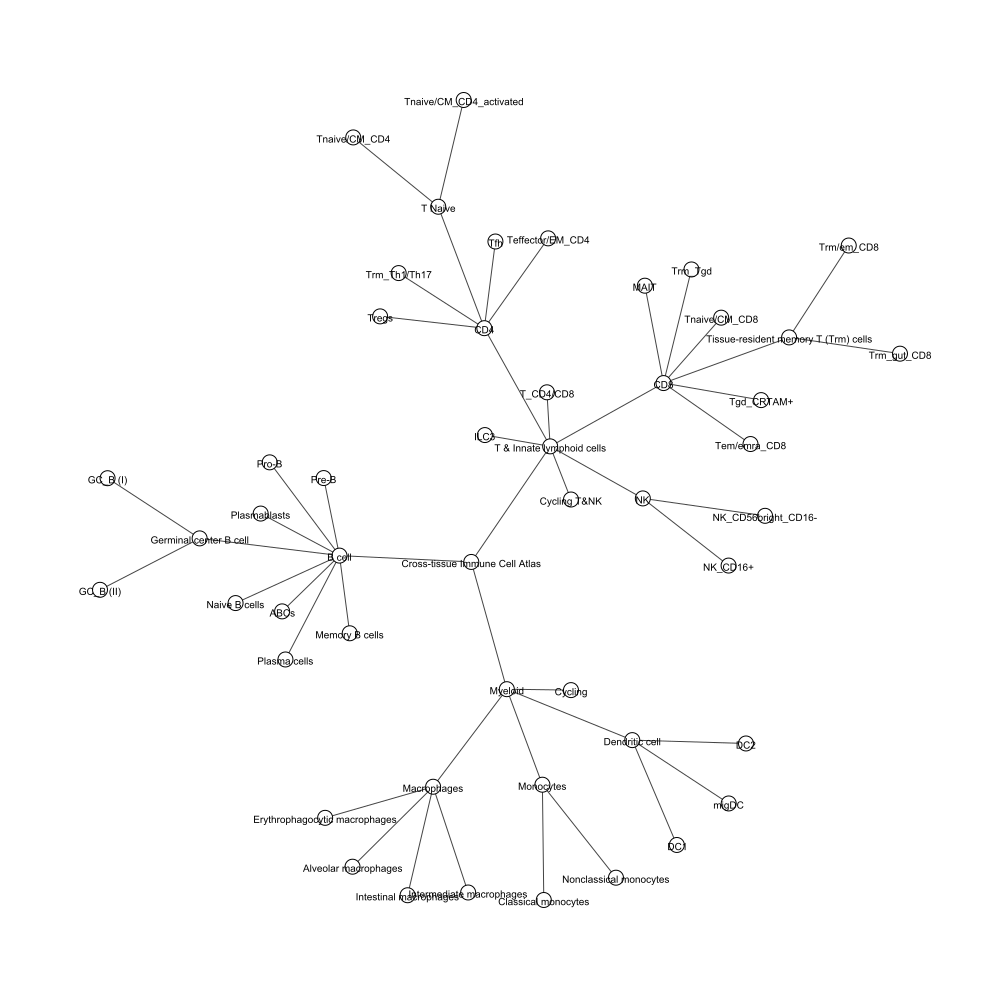

In [7]:
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

In [8]:
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1

In [9]:
dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

In [10]:
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import preprocess as pp
from anndata import AnnData
import vanilla_vae

In [11]:
# --------------Parameters-------------------
embedding_dim = 10
hidden_dim = 512
k_fold = 5
cross_validation = False
num_epoch=50
batch_size=512
feature_selection = True
num_genes = 36601
# --------------Plotting---------------------
plot_loss = True
plot_embedding_space = True
plot_confusion_matrix = True

D = dist_df
D = torch.tensor(D.values, dtype=float)

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=cross_validation, k_fold=k_fold)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

In [12]:
class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

# Pytorch version of the 3 fully connected layers
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def train_nn(l_metric = 0, l_pl = 1, epochs = num_epoch, D_metric=None, D_cost=D, cuda=1):
    D_metric = D_metric.cuda()
    model_vae = vanilla_vae.VanillaVAE(128, embedding_dim, [128]).cuda()
    # model = prototypical_network.LearntPrototypes(model_vae, n_prototypes=D.shape[0],
    #                             prototypes=None, embedding_dim=embedding_dim, device='cuda').cuda()
    
    delta = DistortionLoss(D_metric)
    criterion = nn.CrossEntropyLoss()
    ac = cost.AverageCost(D_cost)

    opt = torch.optim.Adam(model.parameters())
    if plot_loss:
        losses = {'loss_xe':[],'loss_disto':[],'loss_pl':[],'loss_vae':[], 'loss_reconst':[], 'loss_kl':[]}
    if plot_embedding_space:
        embedding_space = {'training_embeddings':[],'training_labels':[],'testing_embeddings':[],'testing_pred_labels':[],'testing_true_labels':[]}
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()

        model.train()
        t0 = time.time()
        if plot_loss:
            batch_losses = {'loss_xe':[],'loss_disto':[],'loss_pl':[],'loss_vae':[], 'loss_reconst':[], 'loss_kl':[]}
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            opt.zero_grad()
            vae_loss = model_vae.loss_function(x_hat, x, mean, log_var, decoder_mu,decoder_log_var, M_N=1)
            pl_loss = PL(centers = model.prototypes.data)
            pl_loss_ = pl_loss(embeddings, y)
            if epoch == epochs and plot_embedding_space:
                embedding_space['training_embeddings'].extend(embeddings)
                embedding_space['training_labels'].extend(y)
            # loss = criterion(out, y) +  l_metric * delta(model.prototypes) + l_pl*pl_loss_ + vae_loss['loss']/10
            # loss = criterion(out, y) +  l_metric * delta(model.prototypes) + l_pl*pl_loss_
            loss = criterion(out, y)
            
            if plot_loss:
                batch_losses['loss_xe'].append(criterion(out, y).detach().cpu())
                batch_losses['loss_disto'].append((l_metric * delta(model.prototypes)).detach().cpu())
                batch_losses['loss_pl'].append(l_pl*pl_loss_.detach().cpu())
                batch_losses['loss_vae'].append(vae_loss['loss'].detach().cpu())
                batch_losses['loss_reconst'].append(vae_loss['Reconstruction_Loss'].detach().cpu())
                batch_losses['loss_kl'].append(vae_loss['KLD'].detach().cpu())

            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
            AC_meter.add(ac(pred.cpu(),y.cpu()))
        
        if plot_loss:
            losses['loss_xe'].append(np.array(batch_losses['loss_xe']).mean())
            losses['loss_disto'].append(np.array(batch_losses['loss_disto']).mean())
            losses['loss_pl'].append(np.array(batch_losses['loss_pl']).mean())
            losses['loss_vae'].append(np.array(batch_losses['loss_vae']).mean())
            losses['loss_reconst'].append(np.array(batch_losses['loss_reconst']).mean())
            losses['loss_kl'].append(np.array(batch_losses['loss_kl']).mean())

        t1 = time.time()
        
        print('Train ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            with torch.no_grad():
                out, embedding_y, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            pred = out.detach()
            if epoch == epochs and plot_embedding_space:
                embedding_space['testing_embeddings'].extend(embedding_y)
                embedding_space['testing_pred_labels'].extend(pred.cpu().numpy())
                embedding_space['testing_true_labels'].extend(y)
            ER_meter.add(pred.cpu(),y)
            AC_meter.add(ac(pred.cpu(),y))
        t1 = time.time()
        print('Test ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))
        results = {}
        results['model'] = model
        if plot_loss:
            results['losses'] = losses
        if plot_embedding_space:
            results['embedding_space'] = embedding_space
    return results

In [13]:
kfold = KFold(n_splits=k_fold, shuffle=True)
# Start print
print('--------------------------------')
model_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')

      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
      
      dataloader_training = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
      dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)

      results = train_nn(D_metric=D, l_metric=1)
      model_list.append(results)
      
      if not cross_validation:
            break

--------------------------------
FOLD 0
--------------------------------
Epoch 1
Train ER 50.46, AC 2.197, time 1.2s
Test ER 29.14, AC 1.087, time 0.1s
Epoch 2
Train ER 26.89, AC 0.982, time 0.6s
Test ER 25.79, AC 0.925, time 0.1s
Epoch 3
Train ER 25.15, AC 0.883, time 0.7s
Test ER 24.98, AC 0.854, time 0.1s
Epoch 4
Train ER 23.85, AC 0.816, time 0.6s
Test ER 24.46, AC 0.831, time 0.1s
Epoch 5
Train ER 22.70, AC 0.762, time 0.6s
Test ER 22.09, AC 0.736, time 0.1s
Epoch 6
Train ER 21.47, AC 0.711, time 0.7s
Test ER 21.59, AC 0.715, time 0.1s
Epoch 7
Train ER 20.23, AC 0.658, time 0.6s
Test ER 20.25, AC 0.660, time 0.1s
Epoch 8
Train ER 19.50, AC 0.629, time 0.7s
Test ER 18.75, AC 0.599, time 0.1s
Epoch 9
Train ER 18.46, AC 0.586, time 0.7s
Test ER 17.78, AC 0.561, time 0.1s
Epoch 10
Train ER 17.67, AC 0.557, time 0.8s
Test ER 17.09, AC 0.531, time 0.1s
Epoch 11
Train ER 17.05, AC 0.534, time 0.7s
Test ER 16.84, AC 0.524, time 0.1s
Epoch 12
Train ER 16.61, AC 0.517, time 0.8s
Test ER 16.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test = dataset[test_indices].obs['Manually_curated_celltype']
pred = 
cm=confusion_matrix(y_test, pred)
# Normalise
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                    yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show(block=False)

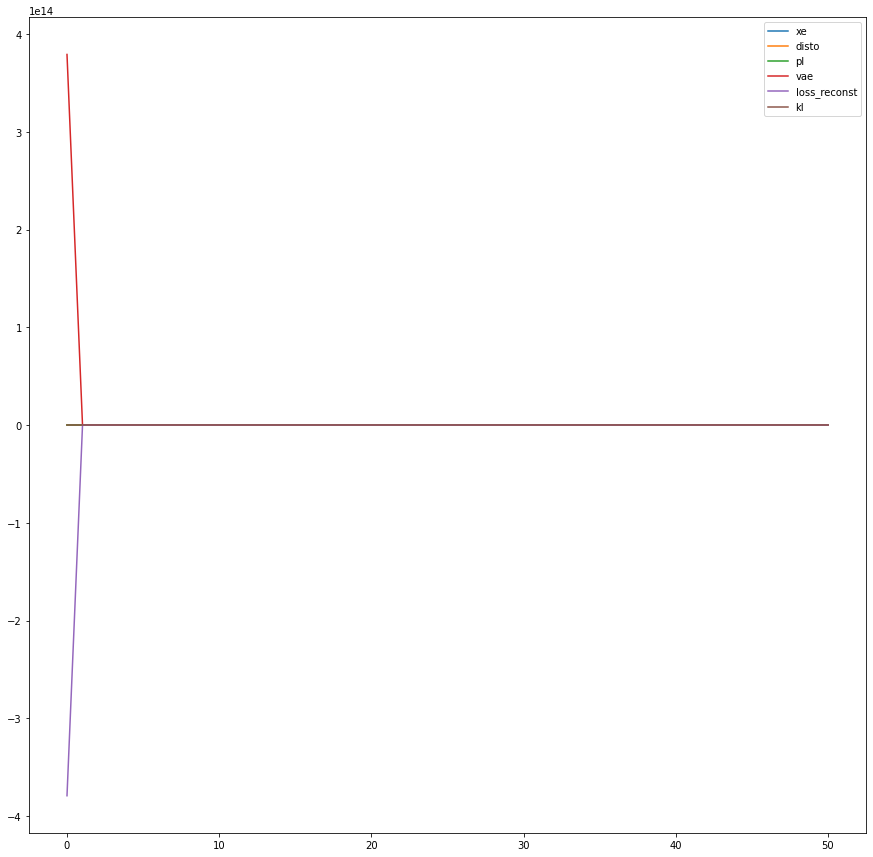

In [14]:
if plot_loss:
    plt.figure(figsize=(15, 15))
    ax = plt.axes()

    x = np.linspace(0, len(results.get('losses')['loss_pl']), len(results.get('losses')['loss_pl']))
    plt.plot(x, np.array(results.get('losses')['loss_xe']), label='xe')
    plt.plot(x, np.array(results.get('losses')['loss_disto']), label='disto')
    plt.plot(x, np.array(results.get('losses')['loss_pl']), label='pl')
    plt.plot(x, np.array(results.get('losses')['loss_vae']), label='vae') 
    plt.plot(x, np.array(results.get('losses')['loss_reconst']), label='loss_reconst') 
    plt.plot(x, np.array(results.get('losses')['loss_kl']), label='kl') 
    plt.legend()

In [15]:
list_ct_num = encoder_celltype.transform(list_ct)
model = results.get('model')
prototypes = model.prototypes.detach().cpu().numpy()

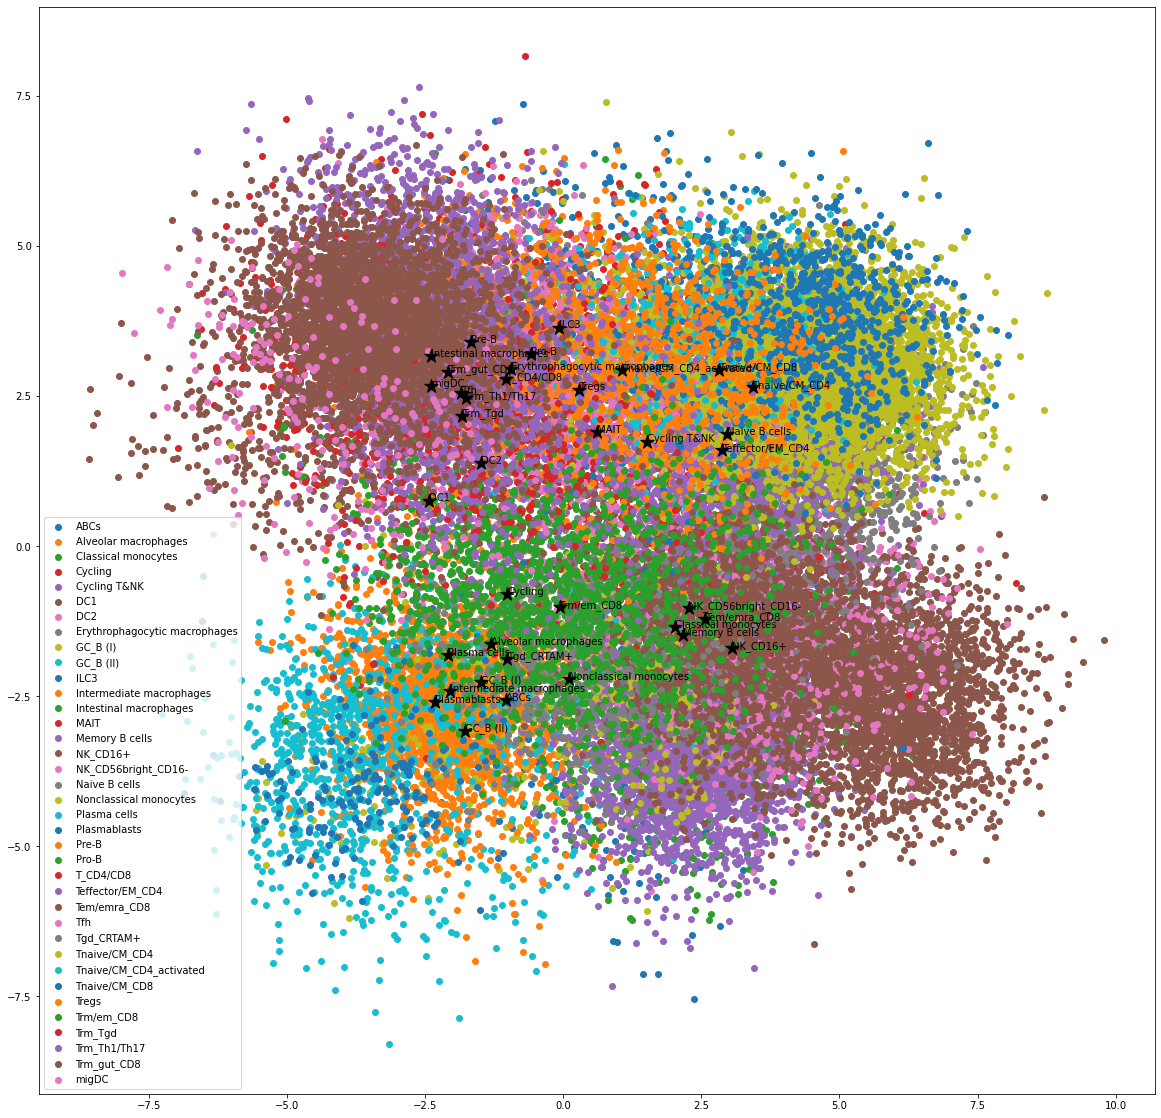

In [16]:
# Training
training_embeddings = results.get('embedding_space')['training_embeddings']
training_embeddings_labels = results.get('embedding_space')['training_labels']
for i in range(len(training_embeddings_labels)):
    if type(training_embeddings[i]) != np.ndarray:
        training_embeddings[i] = training_embeddings[i].detach().cpu().numpy()
    if type(training_embeddings_labels[i]) != np.ndarray:
        training_embeddings_labels[i] = training_embeddings_labels[i].detach().cpu().numpy()
if plot_embedding_space:
    training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(20, 20))
    for color in np.unique(np.array(training_embeddings_labels)):
        i = np.where(np.array(training_embeddings_labels) == color)
        ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
    ax.legend()
    ax.scatter(prototypes[:,0], prototypes[:, 1], marker='*', color='black', s=200)
    
    # plt.plot(prototypes[:,0], prototypes[:, 1],color='b',zorder=1)
    # ax.annotate(encoder_celltype_inner.inverse_transform(list_ct_num), (prototypes[list_ct_num,0], prototypes[list_ct_num, 1]))

    for num in list_ct_num:
        ax.annotate(encoder_celltype.inverse_transform([num])[0], (prototypes[num, 0], prototypes[num,1]))
    plt.show()

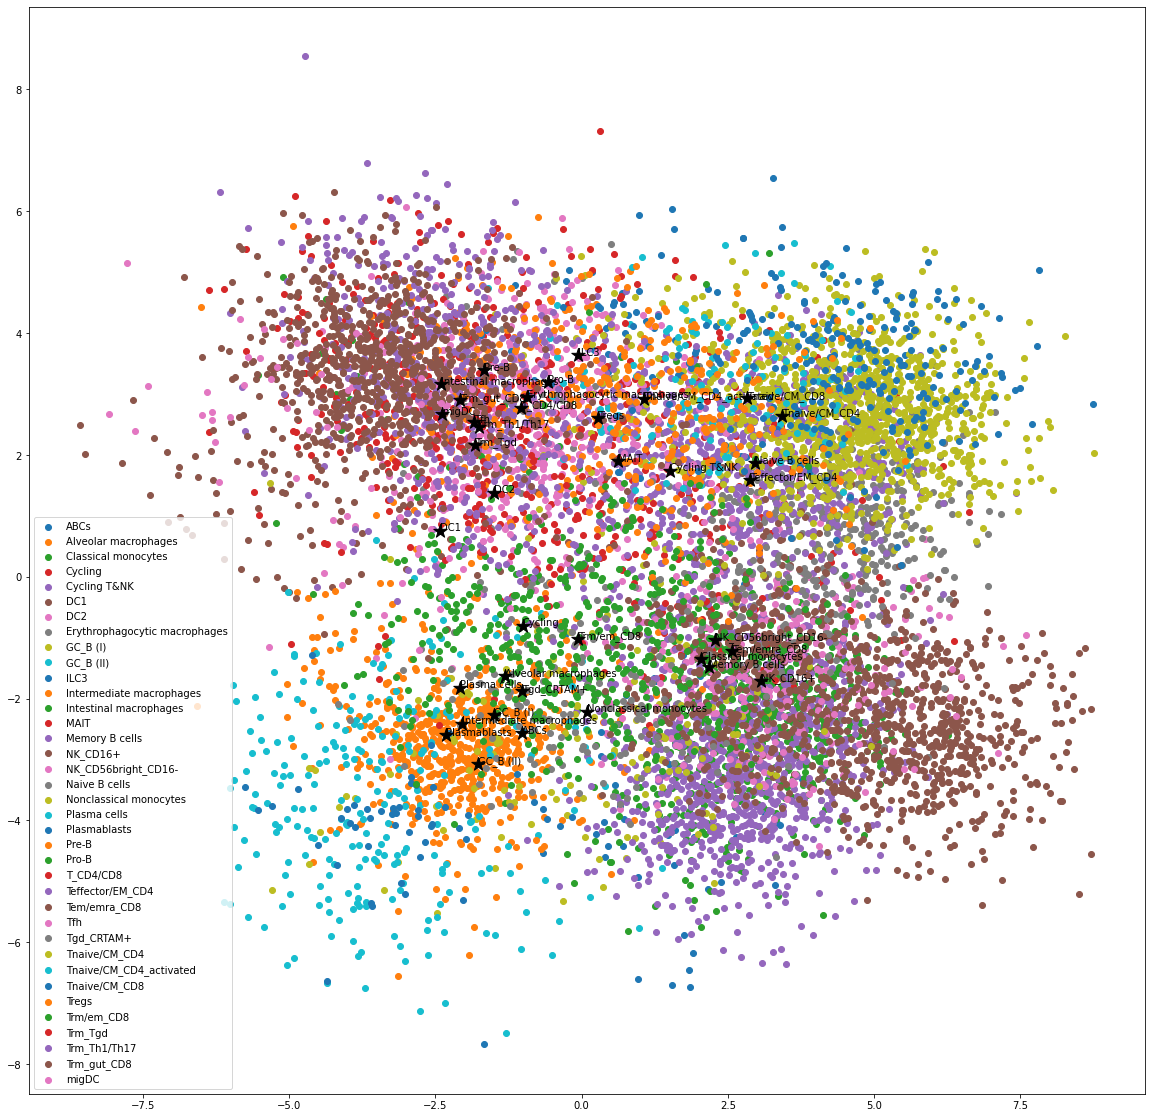

In [17]:
# Testing & True labels
test_embeddings = results.get('embedding_space')['testing_embeddings']
test_true_labels = results.get('embedding_space')['testing_true_labels']
if type(test_embeddings[0]) != np.ndarray:
    for i in range(len(test_embeddings)):
        test_embeddings[i] = test_embeddings[i].cpu().numpy()
        test_true_labels[i] = test_true_labels[i].cpu()
test_true_labels=encoder_celltype.inverse_transform(test_true_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(20, 20))
    for color in np.unique(np.array(test_true_labels)):
        i = np.where(test_true_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    ax.scatter(prototypes[:,0], prototypes[:, 1], marker='*', color='black', s=200)
    for num in list_ct_num:
        ax.annotate(encoder_celltype.inverse_transform([num])[0], (prototypes[num, 0], prototypes[num,1]))
    ax.legend()
    plt.show()

In [24]:
# Testing & Pred labels
test_embeddings = results.get('embedding_space')['testing_embeddings']
test_pred_labels = results.get('embedding_space')['testing_pred_labels'].copy()
for i in range(len(test_pred_labels)):
    test_pred_labels[i] = test_pred_labels[i].argmax()

test_pred_labels=encoder_celltype.inverse_transform(test_pred_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(20, 20))
    for color in np.unique(np.array(test_pred_labels)):
        i = np.where(test_pred_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], label=color)
    ax.scatter(prototypes[list_ct_num,0], prototypes[list_ct_num, 1], marker='*', color='black', s=200)
    for num in list_ct_num:
        ax.annotate(encoder_celltype.inverse_transform([num])[0], (prototypes[num, 0], prototypes[num,1]))
    ax.legend()
    plt.show()

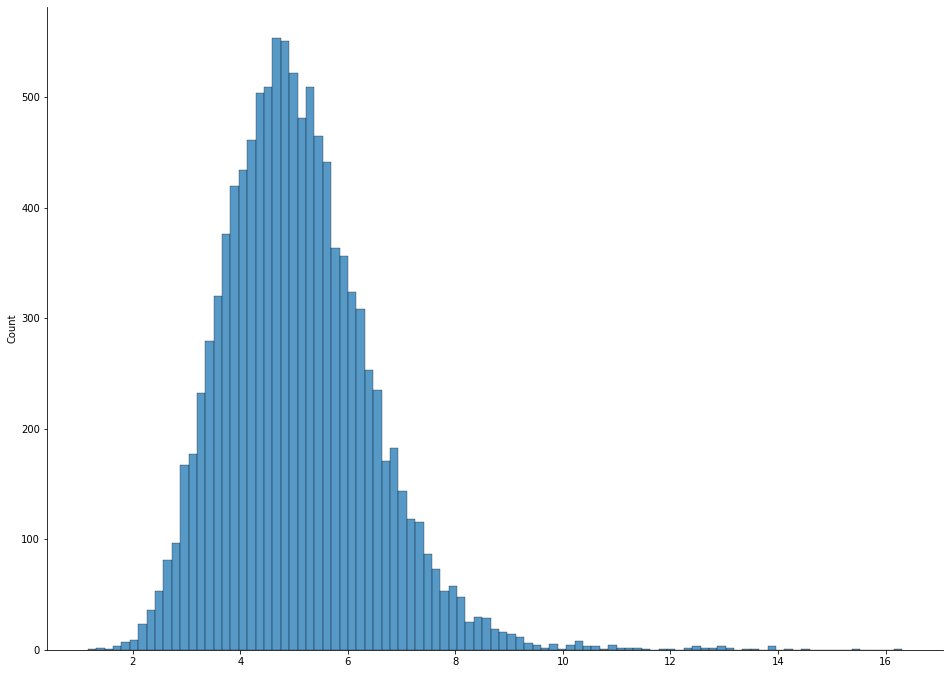

In [19]:
test_pred_dists = results.get('embedding_space')['testing_pred_labels'].copy()
test_pred_labels = encoder_celltype.transform(test_pred_labels)
test_true_labels = encoder_celltype.transform(test_true_labels)
true_pos = []
for i in range(len(test_pred_dists)):
    test_pred_dists[i] = -test_pred_dists[i][test_pred_labels[i]]
    if test_pred_labels[i] == test_true_labels[i]:
        true_pos.append(test_pred_dists[i])

g = sns.displot(test_pred_dists)
g.fig.set_size_inches(15,10)

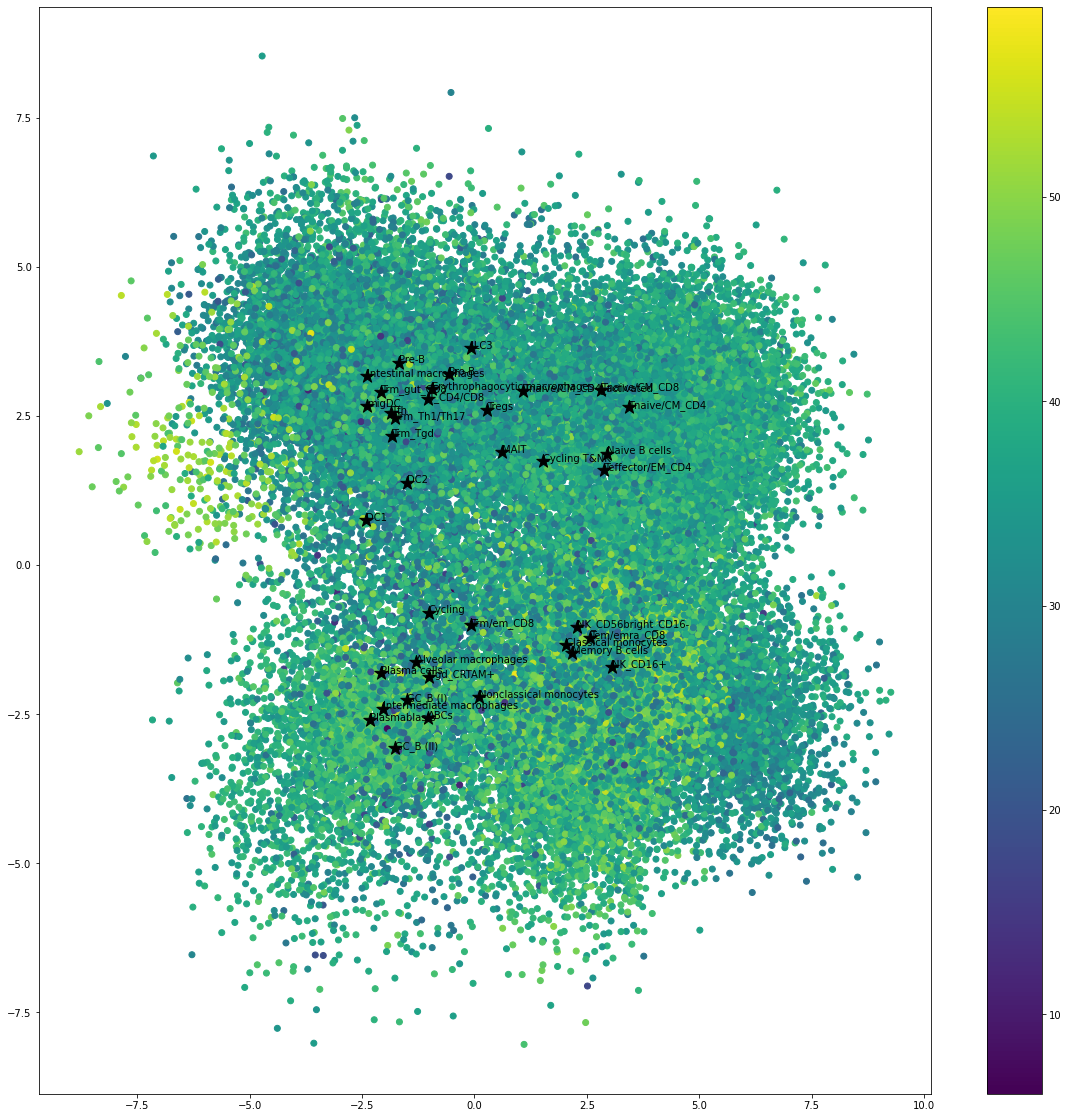

In [20]:
# Training
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[train_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(20, 20))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    ax.scatter(prototypes[list_ct_num,0], prototypes[list_ct_num, 1], marker='*', color='black', s=200)
    for num in list_ct_num:
        ax.annotate(encoder_celltype.inverse_transform([num])[0], (prototypes[num, 0], prototypes[num,1]))
    plt.show()

0.0


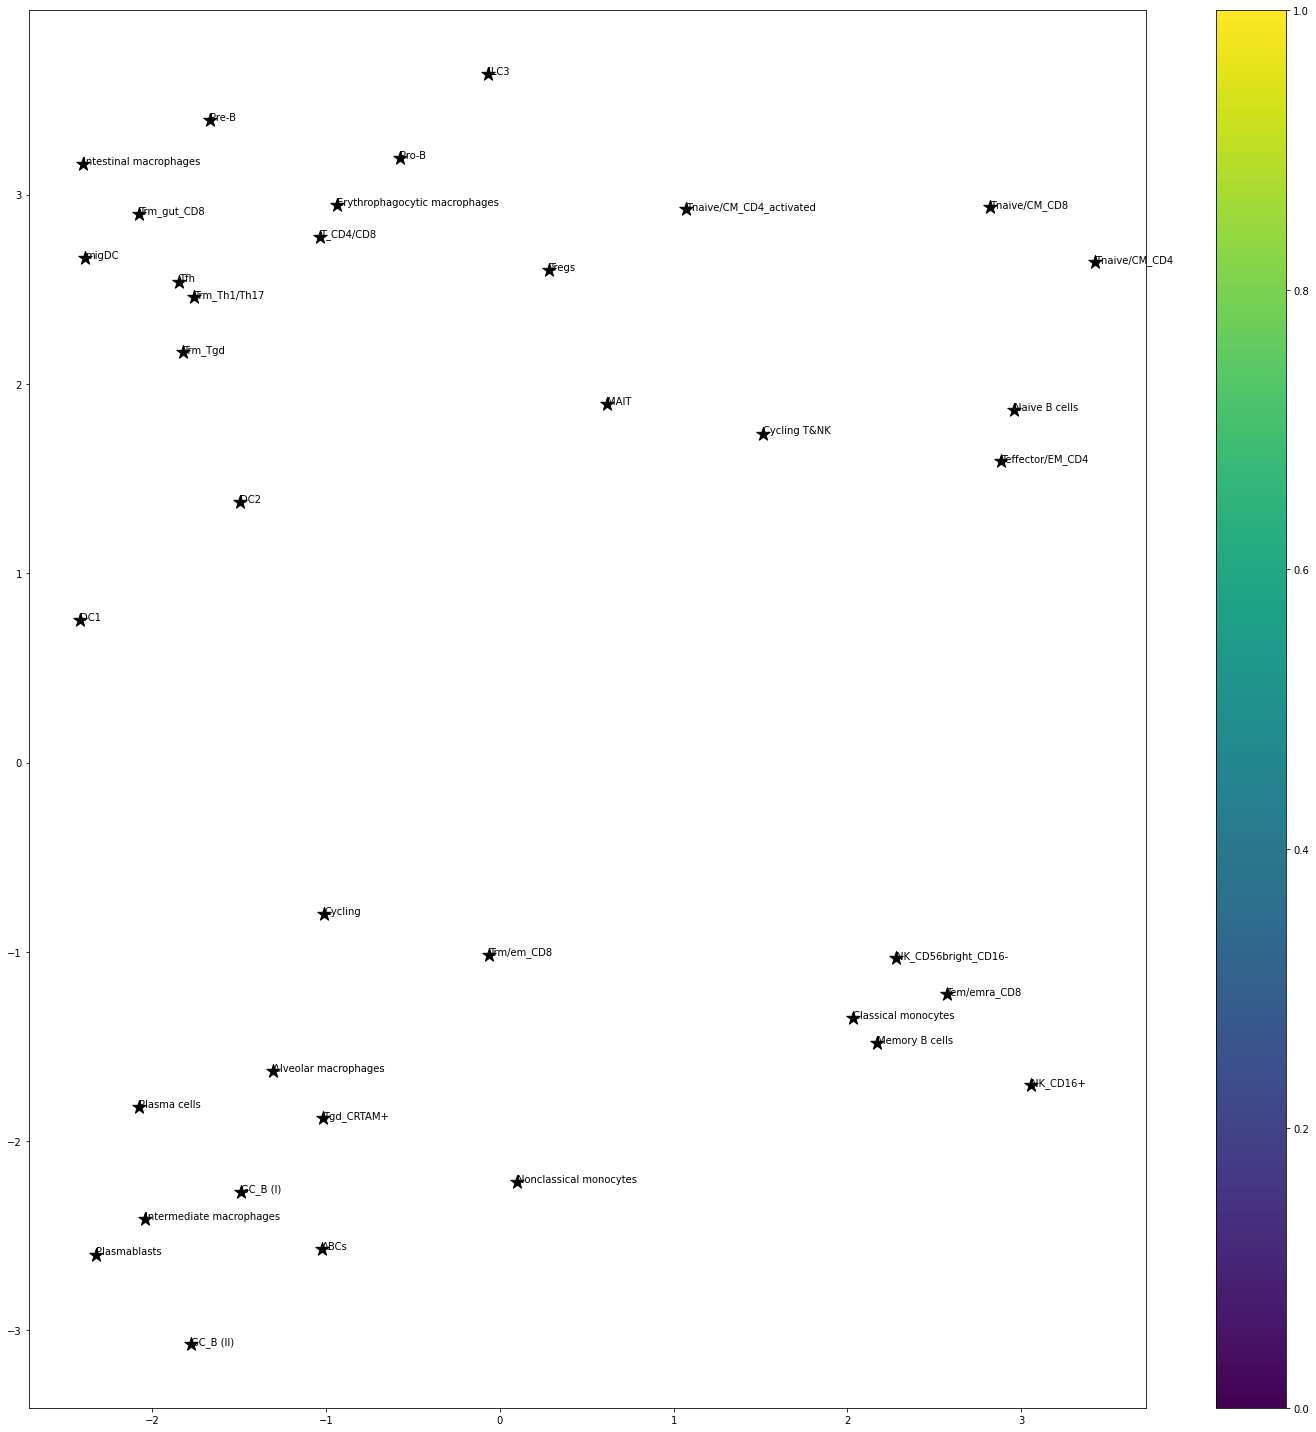

In [21]:
# Training
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[train_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
i = np.where(np.array(embedding_likelihoods) <= 0)[0]
print(len(i)/len(embedding_likelihoods)*100)
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(20, 20))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], c=np.array(embedding_likelihoods)[i])
    fig.colorbar(points)
    ax.scatter(prototypes[list_ct_num,0], prototypes[list_ct_num, 1], marker='*', color='black', s=200)
    for num in list_ct_num:
        ax.annotate(encoder_celltype.inverse_transform([num])[0], (prototypes[num, 0], prototypes[num,1]))
    plt.show()

In [22]:
# Testing
model = results.get('model')
out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_ids].X).cuda())
training_embeddings_likelihoods = helper_fns.log_likelihood_Gaussian(embeddings, mean, log_var)
training_embeddings = []
embedding_likelihoods =[]
for i in range(len(embeddings)):
    if type(embeddings[i]) != np.ndarray:
        training_embeddings.append(embeddings[i].detach().cpu().numpy())
    if type(training_embeddings_likelihoods[i]) != np.ndarray:
        embedding_likelihoods.append(training_embeddings_likelihoods[i].detach().cpu().numpy())
if plot_embedding_space:
    # training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
    fig, ax = plt.subplots(figsize=(20, 20))
    plt.rcParams["figure.autolayout"] = True
    points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=embedding_likelihoods)
    fig.colorbar(points)
    ax.scatter(prototypes[list_ct_num,0], prototypes[list_ct_num, 1], marker='*', color='black', s=200)
    for num in list_ct_num:
        ax.annotate(encoder_celltype.inverse_transform([num])[0], (prototypes[num, 0], prototypes[num,1]))
    plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm=confusion_matrix(test_true_labels, test_pred_labels)
# Normalise
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))), yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)